In [34]:
%pip install nibabel numpy matplotlib

print('✅ Pachete instalate.')

Note: you may need to restart the kernel to use updated packages.
✅ Pachete instalate.



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from glob import glob

print('✅ Importuri încărcate.')

✅ Importuri încărcate.


In [36]:
# --- Configurare calea și constante ---
# Calea absolută pe Windows sau relativă care funcționează
import os as _os_temp
_script_dir = _os_temp.path.dirname(_os_temp.path.abspath(__file__)) if '__file__' in dir() else _os_temp.getcwd()
_data_candidates = [
    'dataset/LUMIERE/Imaging',  # Relativ de script
    '../dataset/LUMIERE/Imaging',  # Relativ de scripts folder
    _os_temp.path.join(_script_dir, '../dataset/LUMIERE/Imaging'),  # Relativ de script
    r'D:\study\licenta\creier\dataset\LUMIERE\Imaging'  # Absolut Windows
]
DATA_ROOT = None
for candidate in _data_candidates:
    if _os_temp.path.exists(candidate):
        DATA_ROOT = candidate
        break
if DATA_ROOT is None:
    DATA_ROOT = r'D:\study\licenta\creier\dataset\LUMIERE\Imaging'  # Fallback

# Configurare culori și harta pentru segmentare
# Order: 0=background, 1=ET, 2=NCR, 3=ED
seg_colors = [
    (0, 0, 0, 1.0),     # background (black)
    (0, 1, 0, 0.6),     # enhancing tumor (green)
    (1, 0, 0, 0.6),     # necrotic core (red)
    (0, 0, 1, 0.6)      # edema (blue)
]
seg_cmap = ListedColormap(seg_colors)

# Definiție etichete segmentare
seg_labels = {
    1: ('Enhancing Tumor', (0, 1, 0, 0.6)),  # green
    2: ('Necrotic Core', (1, 0, 0, 0.6)),    # red
    3: ('Edema', (0, 0, 1, 0.6))             # blue
}

legend_patches = [
    mpatches.Patch(color=color, label=label)
    for _, (label, color) in seg_labels.items()
]

max_slices = 3  # Limitare număr slice-uri afișate per rând

print(f'✅ Cale date: {DATA_ROOT}')
print(f'✅ Culori segmentare configurate.')

✅ Cale date: ../dataset/LUMIERE/Imaging
✅ Culori segmentare configurate.


In [43]:
def get_tumor_centroid_z(seg_volume):
    """Returnează indexul slicei centroid-ului tumorii pe axa Z."""
    coords = np.argwhere(seg_volume > 0)
    return int(np.mean(coords[:, 2])) if coords.size > 0 else None


def load_volumes(patient_path):
    """Încarcă volume segmentation.nii.gz din structura HD-GLIO-AUTO-segmentation/registered."""
    weeks = sorted([d for d in os.listdir(patient_path) if os.path.isdir(os.path.join(patient_path, d))])
    seg_data, tissue_data = {}, {}
    
    for week in weeks:
        week_path = os.path.join(patient_path, week)
        
        # Caută segmentation.nii.gz în HD-GLIO-AUTO-segmentation/registered
        seg_path = None
        for item in os.listdir(week_path):
            if 'HD-GLIO' in item and 'segmentation' in item.lower():
                potential_seg = os.path.join(week_path, item, 'registered', 'segmentation.nii.gz')
                if os.path.exists(potential_seg):
                    seg_path = potential_seg
                    break
                # Încearcă REGISTRED (maiusculă) de asemenea
                potential_seg = os.path.join(week_path, item, 'REGISTRED', 'segmentation.nii.gz')
                if os.path.exists(potential_seg):
                    seg_path = potential_seg
                    break
        
        if seg_path:
            seg_data[week] = nib.load(seg_path).get_fdata().astype(int)
    
    return seg_data, tissue_data


def visualize_patient_seg_masks(patient_path, slice_offset=2):
    """
    Vizualizează slice-uri axiale ale seg_mask.nii pe mai multe săptămâni.
    Rânduri = săptămâni, Coloane = indici slice.
    White matter din tissue_seg.nii se afișează ca underlay gri.
    """
    seg_data, tissue_data = load_volumes(patient_path)
    if not seg_data:
        print(f'⚠️ Nu s-a găsit seg_mask.nii pentru {os.path.basename(patient_path)}.')
        return
    
    # Calculează centroid slice-uri per săptămână
    centroids = {
        week: get_tumor_centroid_z(vol) for week, vol in seg_data.items()
    }
    
    # Selectează slice-uri reprezentative (centroid ± offset)
    slice_indices = set()
    for c in centroids.values():
        if c is not None:
            slice_indices.update([c - slice_offset, c, c + slice_offset])
    slice_indices = sorted([i for i in slice_indices if i >= 0])

    if len(slice_indices) > max_slices:
        slice_indices = np.linspace(min(slice_indices), max(slice_indices), max_slices, dtype=int).tolist()

    # Pregătire figură
    fig, axes = plt.subplots(len(seg_data), len(slice_indices), figsize=(3*len(slice_indices), 3*len(seg_data)))
    if len(seg_data) == 1:
        axes = np.expand_dims(axes, 0)

    for row, (week, seg) in enumerate(sorted(seg_data.items())):
        tissue = tissue_data.get(week, None)
        for col, idx in enumerate(slice_indices):
            ax = axes[row, col]
            if idx < seg.shape[-1]:
                # Underlay white matter
                if tissue is not None:
                    tissue_slice = tissue[..., idx].T.astype(float)
                    tissue_slice = tissue_slice / tissue_slice.max() if tissue_slice.max() > 0 else tissue_slice
                    ax.imshow(tissue_slice, cmap='gray', origin='lower')

                # Overlay segmentare cu colormap custom
                seg_slice = seg[..., idx].T
                rgba = seg_cmap(seg_slice)
                rgba[seg_slice == 0, -1] = 0.0
                ax.imshow(rgba, origin='lower')

                ax.set_title(f"{week} | z={idx}", fontsize=8)

            ax.axis('off')

    plt.tight_layout()
    fig.legend(
        handles=legend_patches,
        loc='lower center',
        ncol=len(seg_labels),
        bbox_to_anchor=(0.5, 1.0),
        bbox_transform=fig.transFigure,
        fontsize=8,
        title=f"{os.path.basename(patient_path)}"
    )
    plt.show()

print('✅ Funcții de vizualizare definite.')

✅ Funcții de vizualizare definite.


In [40]:
# --- Verificare dataset ---
print(f'Cale: {DATA_ROOT}')
print(f'Există: {os.path.exists(DATA_ROOT)}')

if os.path.exists(DATA_ROOT):
    patients = sorted([d for d in os.listdir(DATA_ROOT) if os.path.isdir(os.path.join(DATA_ROOT, d))])
    print(f'✅ Pacienți găsiți: {len(patients)}')
    print(f'   Ex: {patients[:5]}')
    
    # Verificare prim pacient
    if patients:
        first_patient = os.path.join(DATA_ROOT, patients[0])
        weeks = sorted(os.listdir(first_patient))
        print(f'\n✅ Pacient exemplu: {patients[0]}')
        print(f'   Săptămâni: {len(weeks)}')
        print(f'   Ex: {weeks[:5]}')
else:
    print('❌ EROARE: Calea nu există!')

Cale: ../dataset/LUMIERE/Imaging
Există: True
✅ Pacienți găsiți: 91
   Ex: ['Patient-001', 'Patient-002', 'Patient-003', 'Patient-004', 'Patient-005']

✅ Pacient exemplu: Patient-001
   Săptămâni: 4
   Ex: ['week-000-1', 'week-000-2', 'week-044', 'week-056']



--- Vizualizez Patient-001 (1/3) ---


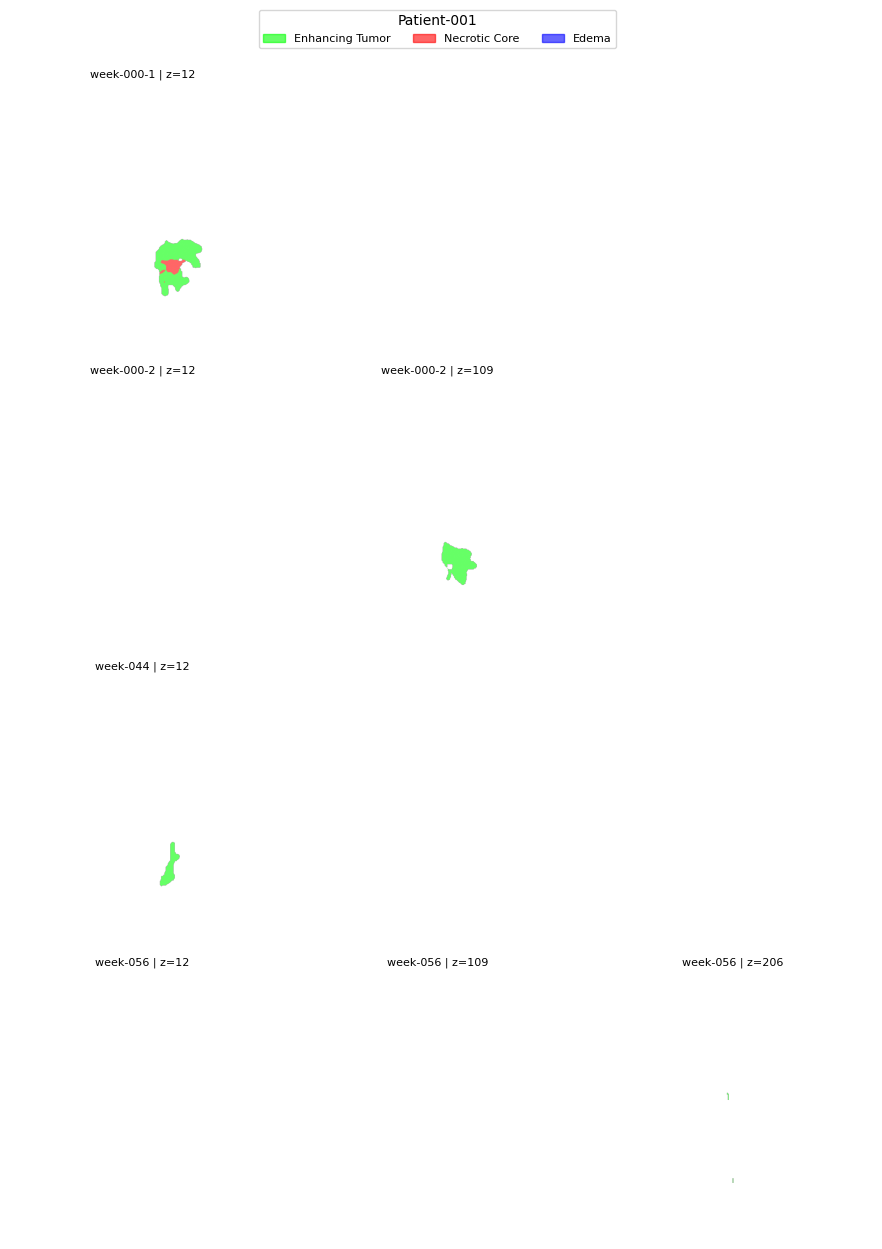


--- Vizualizez Patient-002 (2/3) ---


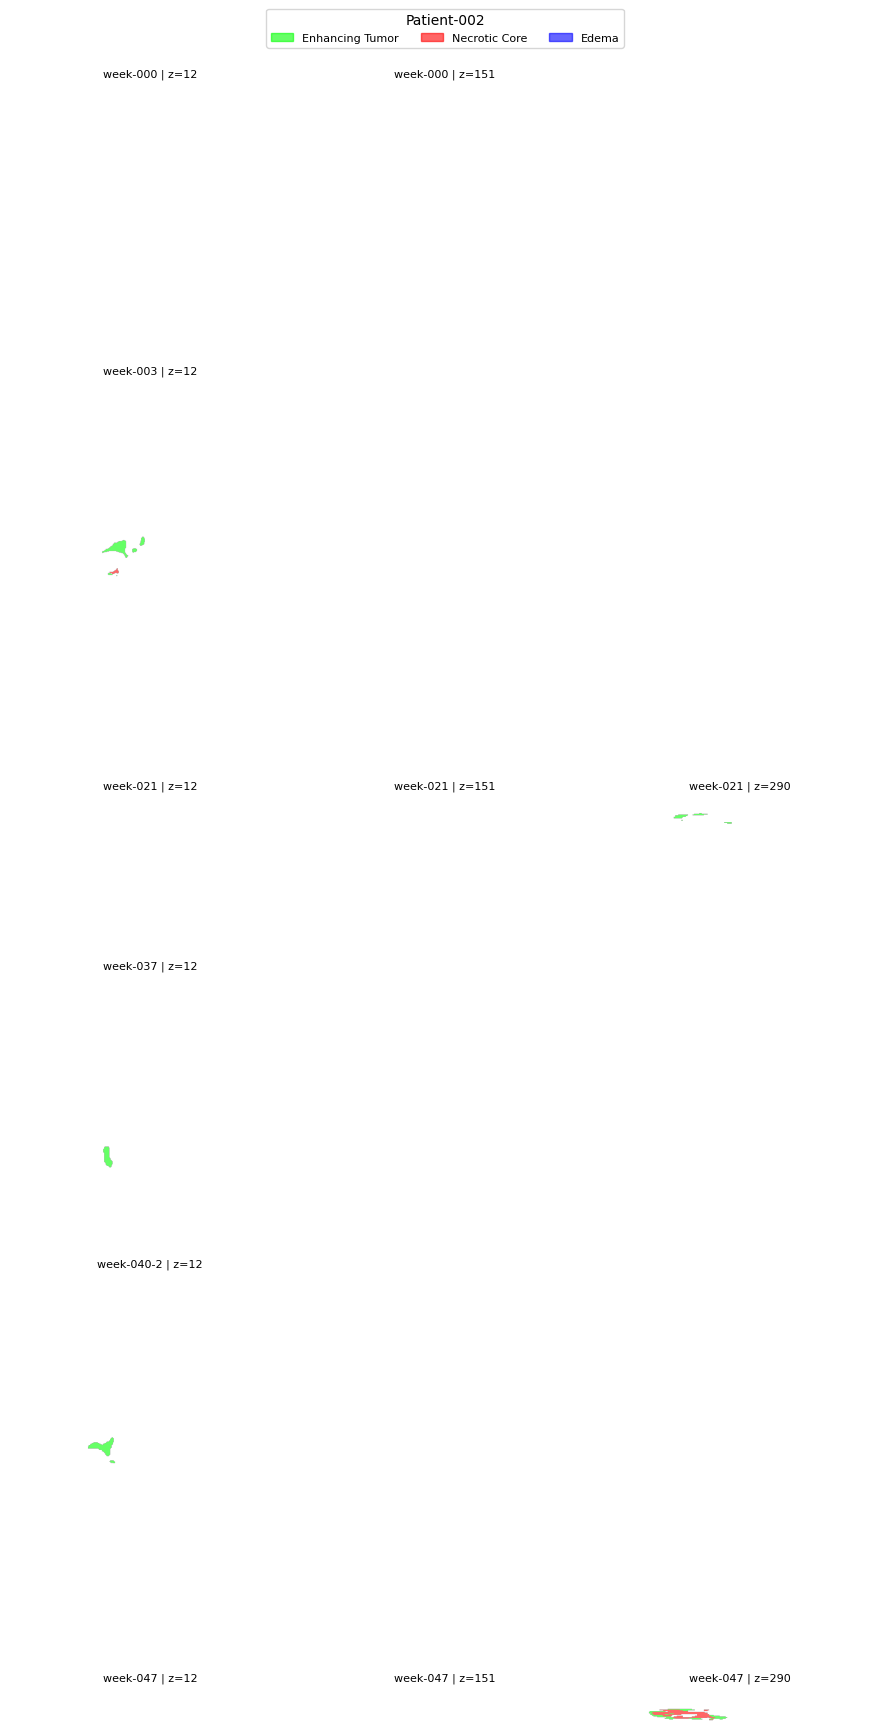


--- Vizualizez Patient-003 (3/3) ---


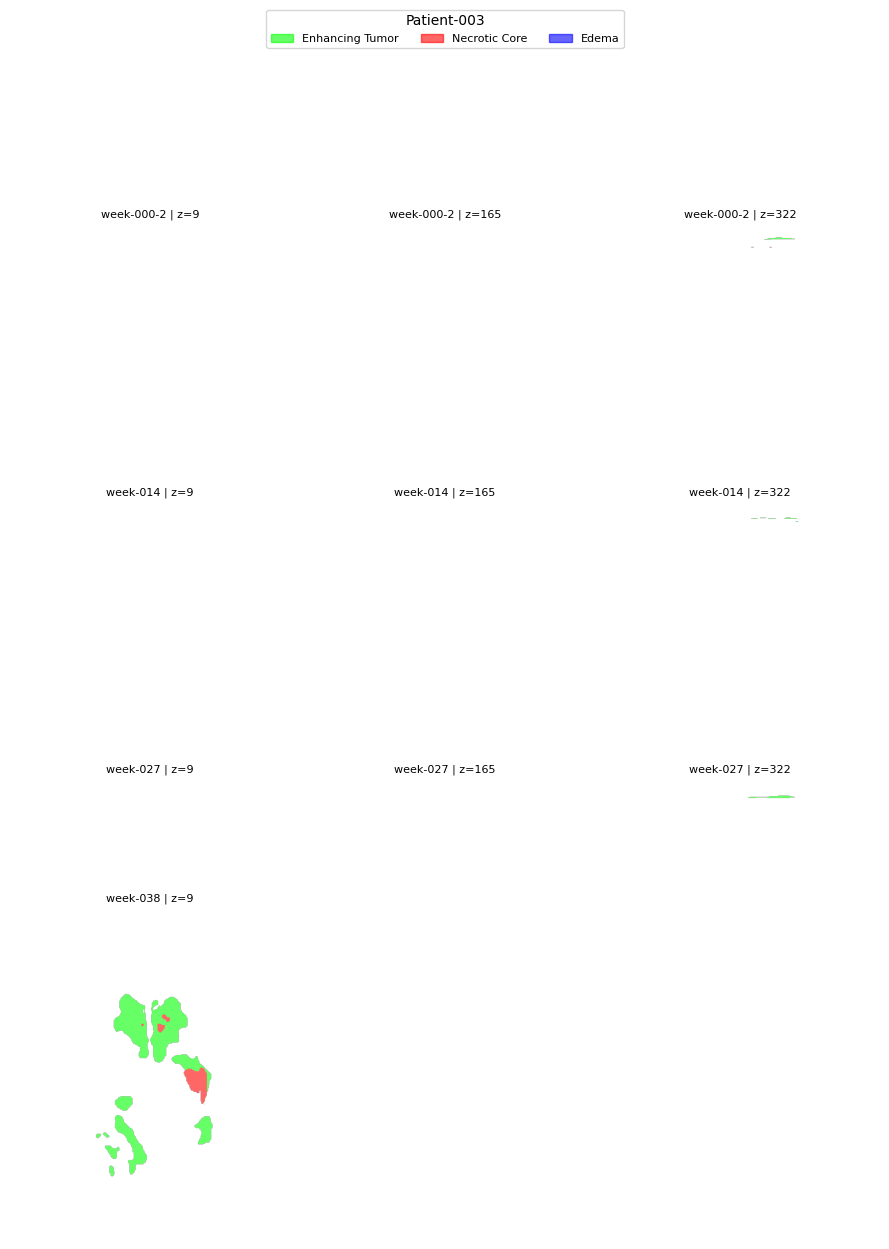

In [44]:
# --- Vizualizare pacienți ---
if os.path.exists(DATA_ROOT):
    patients = sorted([d for d in os.listdir(DATA_ROOT) if os.path.isdir(os.path.join(DATA_ROOT, d))])
    
    for i, patient in enumerate(patients[:3]):  # Primii 3 pacienți
        patient_path = os.path.join(DATA_ROOT, patient)
        print(f'\n--- Vizualizez {patient} ({i+1}/3) ---')
        try:
            visualize_patient_seg_masks(patient_path, slice_offset=2)
        except Exception as e:
            print(f'⚠️ Eroare: {e}')
else:
    print('❌ Dataset-ul nu este disponibil.')

In [42]:
%pip install nibabel numpy matplotlib

# Imports used by the visualization notebook
import nibabel as nib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

print('Dependințele (posibil) instalate și modulele importate.')

Dependințele (posibil) instalate și modulele importate.




[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

from matplotlib.colors import ListedColormap


# Limit number of slices shown per row
max_slices = 3  

# Custom colormap for seg_mask.nii
# Order: 0=background, 1=ET, 2=NCR, 3=ED
seg_colors = [
    (0, 0, 0, 1.0),     # background (black)
    (0, 1, 0, 0.6),     # enhancing tumor (green)
    (1, 0, 0, 0.6),     # necrotic core (red)
    (0, 0, 1, 0.6)      # edema (blue)
]
seg_cmap = ListedColormap(seg_colors)

# Define segmentation classes and colors
seg_labels = {
    1: ('Enhancing Tumor', (0, 1, 0, 0.6)),  # green
    2: ('Necrotic Core', (1, 0, 0, 0.6)),    # red
    3: ('Edema', (0, 0, 1, 0.6))             # blue
}

# Create legend handles
legend_patches = [
    mpatches.Patch(color=color, label=label)
    for _, (label, color) in seg_labels.items()
]


def get_tumor_centroid_z(seg_volume):
    """Return tumor centroid slice index along Z-axis (axial projection)."""
    coords = np.argwhere(seg_volume > 0)
    return int(np.mean(coords[:, 2])) if coords.size > 0 else None


def load_volumes(patient_path):
    """Load seg_mask.nii and tissue_seg.nii volumes for a patient (if present)."""
    weeks = sorted(os.listdir(patient_path))
    seg_data, tissue_data = {}, {}
    for week in weeks:
        seg_path = os.path.join(patient_path, week, 'seg_mask.nii')
        tissue_path = os.path.join(patient_path, week, 'tissue_seg.nii')
        if os.path.exists(seg_path):
            seg_data[week] = nib.load(seg_path).get_fdata().astype(int)
        if os.path.exists(tissue_path):
            tissue_data[week] = nib.load(tissue_path).get_fdata().astype(int)
    return seg_data, tissue_data


def visualize_patient_seg_masks(patient_path, slice_offset=2):
    """
    Visualize axial slices of seg_mask.nii across multiple weeks.
    Rows = weeks, Columns = slice indices.
    White matter from tissue_seg.nii is shown as gray underlay.
    """
    seg_data, tissue_data = load_volumes(patient_path)
    if not seg_data:
        print("No seg_mask.nii found for this patient.")
        return
    
    # Compute centroid slices per week
    centroids = {
        week: get_tumor_centroid_z(vol) for week, vol in seg_data.items()
    }
    
    # Pick representative slice indices (centroid ± offset)
    slice_indices = set()
    for c in centroids.values():
        if c is not None:
            slice_indices.update([c - slice_offset, c, c + slice_offset])
    slice_indices = sorted([i for i in slice_indices if i >= 0])

    if len(slice_indices) > max_slices:
        # Sample evenly spaced
        slice_indices = np.linspace(min(slice_indices), max(slice_indices), max_slices, dtype=int).tolist()
# Prepare figure
    fig, axes = plt.subplots(len(seg_data), len(slice_indices), figsize=(3*len(slice_indices), 3*len(seg_data)))
    if len(seg_data) == 1:
        axes = np.expand_dims(axes, 0)  # ensure 2D array

    for row, (week, seg) in enumerate(sorted(seg_data.items())):
        tissue = tissue_data.get(week, None)
        for col, idx in enumerate(slice_indices):
            ax = axes[row, col]
            if idx < seg.shape[-1]:
                # Underlay white matter (label=2 in tissue_seg.nii)
                if tissue is not None:
                    tissue_slice = tissue[..., idx].T.astype(float)
                    tissue_slice = tissue_slice / tissue_slice.max() if tissue_slice.max() > 0 else tissue_slice
                    ax.imshow(tissue_slice, cmap='gray', origin='lower')

                # Overlay segmentation with custom colormap
                seg_slice = seg[..., idx].T

                # Map to RGBA with the custom colormap
                rgba = seg_cmap(seg_slice)

                # Make background (label 0) transparent
                rgba[seg_slice == 0, -1] = 0.0   # set alpha channel to 0 for background

                # Now overlay
                ax.imshow(rgba, origin='lower')

                # Set title
                ax.set_title(f"{week} | z={idx}", fontsize=8)

            ax.axis('off')

    plt.tight_layout()
    fig.legend(
        handles=legend_patches,
        loc='lower center',
        ncol=len(seg_labels),
        bbox_to_anchor=(0.5, 1.0),  # move legend outside plot
        bbox_transform=fig.transFigure, # transform relative to figure box
        # frameon=False,  # disable frame around the legend
        fontsize=8,
        title=f"{os.path.basename(patient_path)}"
    )
    # plt.subplots_adjust(top=0.90)
    plt.show()
# Compatibility alias for a common misspelling
def vizualize_patient_seg_masks(patient_path, slice_offset=2):
    """Alias for backward compatibility with typoed calls."""
    return visualize_patient_seg_masks(patient_path, slice_offset=slice_offset)

In [ ]:
import os
DATA_ROOT = r'D:\study\licenta\creier\dataset\LUMIERE\Imaging'
print('Exists:', os.path.exists(DATA_ROOT))
patients = sorted([d for d in os.listdir(DATA_ROOT) if os.path.isdir(os.path.join(DATA_ROOT,d))])
print('Patients found:', len(patients), patients[:5])
# Inspect first patient weeks
p0 = os.path.join(DATA_ROOT, patients[0])
print('Weeks (sample):', sorted(os.listdir(p0))[:10])


Exists: True
Patients found: 91 ['Patient-001', 'Patient-002', 'Patient-003', 'Patient-004', 'Patient-005']
Weeks (sample): ['week-000-1', 'week-000-2', 'week-044', 'week-056']


In [ ]:
from glob import glob

# Visualize (Kaggle path example)
for patient_path in sorted(glob(os.path.join('dataset/LUMIERE/Imaging', '*'))):
    try:
        print(f'Vizualizez: {patient_path}')
        visualize_patient_seg_masks(patient_path, slice_offset=2)
    except Exception as e:
        print(f'⚠️ Eroare la vizualizare pentru {patient_path}: {e}')
